In [162]:
from pathlib import Path 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from collections import OrderedDict
import sys
import os
import seaborn as sns
import researchpy as rp
import statsmodels.formula.api as smf
import scipy.stats as stats
import warnings

from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.ticker as ticker

#sys.path.append('/Users/alina/Desktop/MIT/code/ADHD/MTA/helper')
from helper import rr, prep, var_dict, plot

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [163]:
if Path('/Volumes/Samsung_T5/MIT/mta').exists():
    data_root =     '/Volumes/Samsung_T5/MIT/mta'
    data_derived = '/Volumes/Samsung_T5/MIT/mta/output/derived_data'
else: 
    data_root = '/Users/alina/Desktop/MIT/code/data'
    data_derived = '/Users/alina/Desktop/MIT/code/data/output/derived_data'

In [164]:
baseline_var = ['src_subject_id', 'interview_date', 'interview_age', 'sex', 'site', 'days_baseline']
dtypes_baseline = { 'src_subject_id' : 'str',
                    'interview_date': 'str' , 
                    'interview_age' : 'int64' ,
                    'sex' : 'str', 
                    'site' : 'int64' ,
                    'days_baseline':  'int64',
                    'version_form': 'str'}

version_form = ['version_form']
treat_group_file = 'treatment_groups.csv'
trt_names = pd.read_csv(Path(data_derived, treat_group_file))

qsts =['snap', 'ssrs'] #, 'masc', 'pc']


In [195]:
#snap

excellent_resp_var = ['snaxrsp'] # SNAP Adolescent Excellent Responder Score ]

inattention_vars_x = [
                    #'snap_inattn_avg', # Average of inattention items -- EXCLUDED [999]
                    'snainatx', #Inattention (mean score) 
                    ] 
inattention_vars_t = [#'snap_inattn_totalscore', # Sum of inattention items',-- EXCLUDED [999]
                      "snainatt"]# Inattention (total score) 

#similar 
hyperact_vars_x = ["snahypax",# Hyperactivity (mean score) 
                    #'snap_hyp_avg',#Average of hyperactivity/impulsivity items - EXCLUDED [999]
                    'snahix'] #Hyperactive/Impulsive (mean score)


                

hyperact_vars_t =["snahypat", #Hyperactivity (total score) ]'snap_hyp_totalscore',# Sum of hyperactivity/impulsivity items 
                  'snahit']# Hyperactive/Impulsive (total score) ]

odd_vars = ['snaoddx', # ODD (mean score) 
            'snaoddt' ]# ODD (total score) ]

snap_vars_list =  np.concatenate((excellent_resp_var, inattention_vars_x, inattention_vars_t, hyperact_vars_x,hyperact_vars_t, odd_vars))
snap_vars_dict = dict(zip(["ex_resp", "inatt_x", "inatt_t" , "hyp_x", "hyp_t", "odd"], [ excellent_resp_var, inattention_vars_x, inattention_vars_t , hyperact_vars_x, hyperact_vars_t,  odd_vars ]))
#ssrs
ss_vars = ['sspsconx' ,#Social Conduct raw score 
            'ssptossx'] #Total social skills mean score ]

int_vars = ['sspintx']# Internalizing behavior mean score ]
ssrs_vars_list = np.concatenate((ss_vars, int_vars))
ssrs_vars_dict = dict(zip(["ss", "int"], [ss_vars, int_vars]))

qsts_vars_dict = dict(zip(qsts, [snap_vars_dict, ssrs_vars_dict]))
vars_dict = { **snap_vars_dict, **ssrs_vars_dict}


In [173]:

snap_file = 'snap01.txt'
ssrs_file = 'ssrs01.txt'
masc_file = 'masc_p01.txt'
parent_child_file = 'pcrc01.txt'
wechsler_file = 'wiat_iiip201.txt'
treat_group_file = 'treatment_groups.csv'

In [167]:
snap = prep.get_data(Path(data_root, snap_file), treat_group= trt_names,  columns=[baseline_var, snap_vars_list], version_form=True, set_dtypes=True)
ssrs = prep.get_data(Path(data_root, ssrs_file), treat_group= trt_names,  columns=[baseline_var, ssrs_vars_list], version_form=True, set_dtypes=True)
#masc = pd.read_csv(Path(data_root, masc_file), delimiter='\t')
#pc = pd.read_csv(Path(data_root, parent_child_file), delimiter='\t')
#wechsler = pd.read_csv(Path(data_root, wechsler_file), delimiter='\t')


data_dict = dict(zip(['snap', 'ssrs'], [snap, ssrs]) )#, masc, pc]))

Success
Success


In [174]:
for var in snap_vars_dict.keys():
    print(var)
    for out in snap_vars_dict[var]:
        print(out, data_dict['snap'][snap_vars_dict[var]][out].dropna().shape)
        print(data_dict['snap'][snap_vars_dict[var]][out].unique())

ex_resp
snaxrsp (14392,)
[1. 0.]
inatt_x
snap_inattn_avg (14392,)
[999]
snainatx (14392,)
[0.11 0.33 0.   2.   1.   1.11 0.44 0.67 1.78 2.56 2.44 2.67 1.67 1.89
 1.33 1.56 1.44 1.63 1.22 2.38 2.89 2.22 0.78 0.56 0.89 3.   2.33 1.88
 0.22 1.38 0.13 2.11 2.78 2.13 1.57 0.88 0.5  1.43 1.75 2.75 2.5  0.57
 2.25 1.5  0.71 0.75 0.25 0.29 0.63 2.88 1.25 1.13 1.71 0.38 2.63 2.29]
inatt_t
snap_inattn_totalscore (14392,)
[999]
snainatt (14392,)
[ 1.    3.    0.   18.    9.   10.    4.    6.   16.   23.   22.   24.
 15.   17.   12.   14.   13.   14.63 11.   21.38 26.   20.    7.    5.
  8.   27.   21.   16.88  2.   12.38  1.13 19.   25.   19.13 14.14  7.88
  4.5  12.86 15.75 24.75 22.5   5.14 20.25 13.5   6.43  6.75  2.25  2.57
  5.63 25.88 11.25 10.13 15.43  3.38 23.63 20.57]
hyp_x
snahypax (14392,)
[0.   1.17 0.5  1.   0.33 0.17 0.67 3.   2.6  2.83 1.2  1.33 1.6  0.83
 1.83 2.   2.33 1.67 1.5  2.5  2.4  2.17 0.8  2.67 1.8  0.6  0.2  2.2
 1.4  0.4  2.8 ]
snap_hyp_avg (14392,)
[999]
snahix (14392

In [171]:
data_dict['snap']['snap_inattn_avg'].shape

(14392,)

In [184]:
varss = "hyp_x"
print(vars_dict[varss])
data_dict['snap'] = data_dict['snap'][data_dict['snap'][vars_dict[varss][0] ]!= 999]



['snahypax', 'snahix']


In [202]:
def compare_vars(data,  varss_list, plot = False, trt_name = None):
    
    if trt_name is not None: 
        data = data[data['trtname'] == trt_name]


    
    data_long = pd.melt(data, id_vars=['src_subject_id', 'days_baseline'], 
                    value_vars = varss_list ,
                    var_name='variable', value_name='value')
    model = smf.mixedlm("value ~ C(variable) * days_baseline", 
                    data_long, 
                    groups=data_long["src_subject_id"])

    result = model.fit()

# Output the summary of the model
    print(result.summary())
    
    if plot : 
        plt.figure(figsize=(15,10))
    sns.lineplot(x='days_baseline', y='value', hue='variable', data=data_long, ci='sd')

    plt.xlabel('Time')
    plt.ylabel('Value')
    if trt_name is not None: 
        plt.title('Comparison of {} Over Time for Treatment Arm {}'.format(varss_list, trt_name))
    plt.legend(title='Variable')
    plt.show()
        
    return result
    

In [206]:
trt_names = ['M', 'P', 'C', 'A']

                      Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         value     
No. Observations:          5342            Method:                     REML      
No. Groups:                144             Scale:                      0.5091    
Min. group size:           6               Log-Likelihood:             -5959.0018
Max. group size:           68              Converged:                  Yes       
Mean group size:           37.1                                                  
---------------------------------------------------------------------------------
                                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                              1.448    0.034  42.800 0.000  1.381  1.514
C(variable)[T.snahypax]               -0.041    0.025  -1.613 0.107 -0.091  0.009
days_baseline                         

/var/folders/hf/frc4nxb532j7gqr3_36l6kmh0000gn/T/ipykernel_5770/2443473188.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x='days_baseline', y='value', hue='variable', data=data_long, ci='sd')


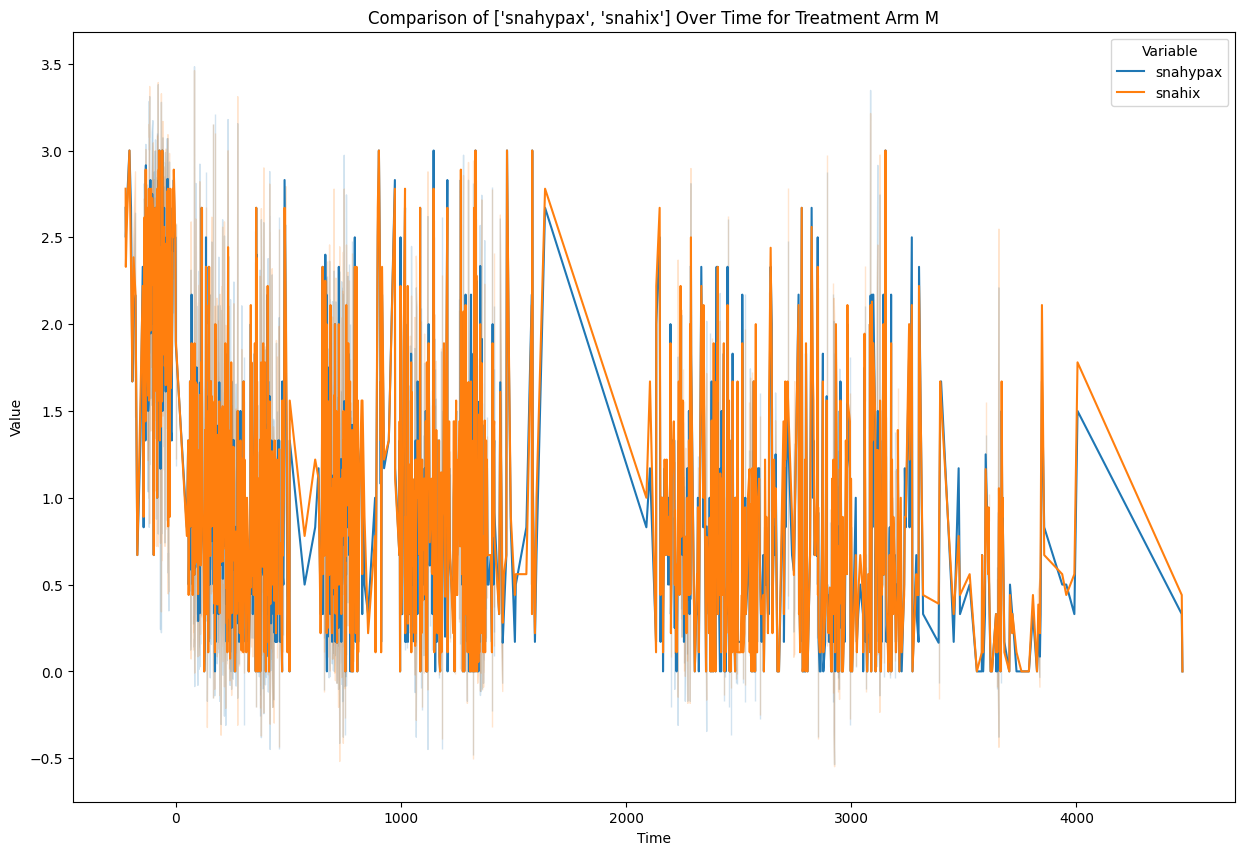

                      Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         value     
No. Observations:          5730            Method:                     REML      
No. Groups:                144             Scale:                      0.4203    
Min. group size:           10              Log-Likelihood:             -5868.9537
Max. group size:           66              Converged:                  Yes       
Mean group size:           39.8                                                  
---------------------------------------------------------------------------------
                                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                              1.599    0.037  43.116 0.000  1.526  1.672
C(variable)[T.snahypax]               -0.022    0.023  -0.975 0.330 -0.066  0.022
days_baseline                         

/var/folders/hf/frc4nxb532j7gqr3_36l6kmh0000gn/T/ipykernel_5770/2443473188.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x='days_baseline', y='value', hue='variable', data=data_long, ci='sd')


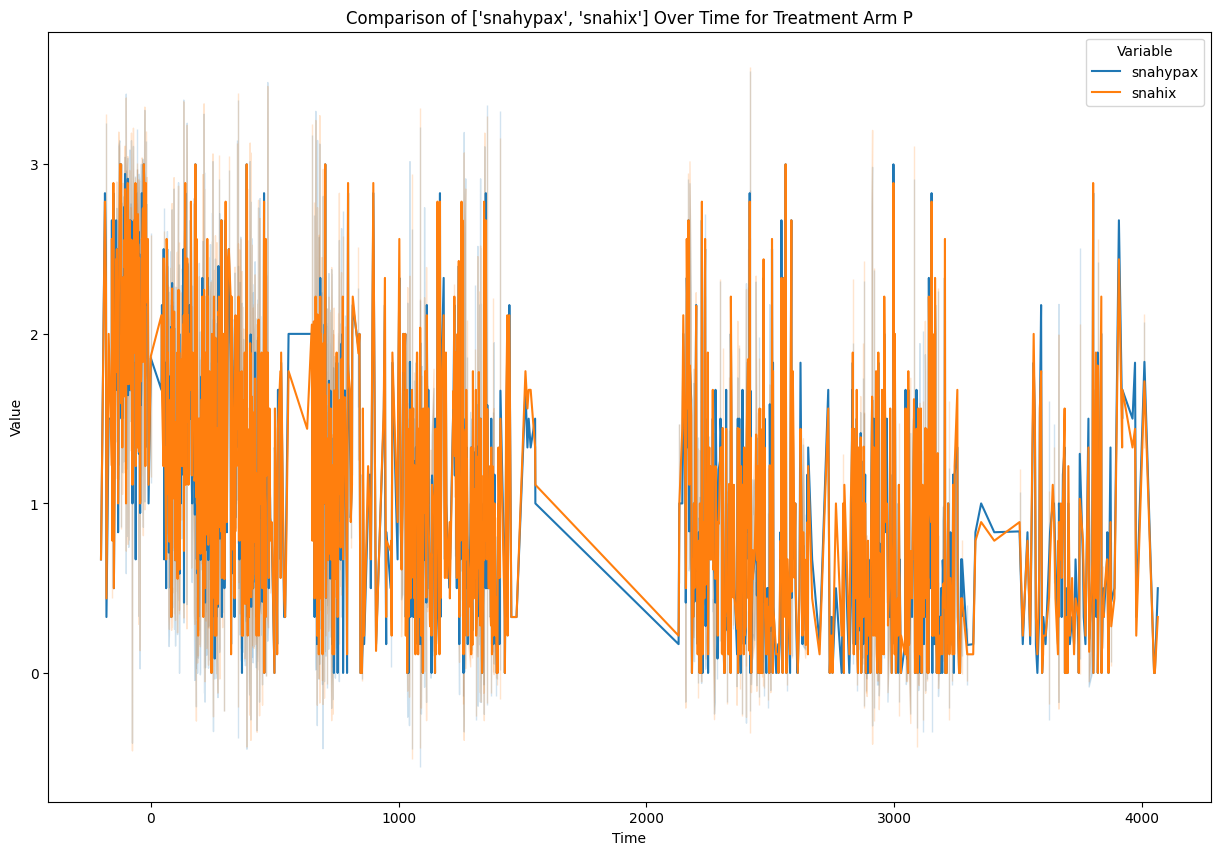

                      Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         value     
No. Observations:          5890            Method:                     REML      
No. Groups:                145             Scale:                      0.4746    
Min. group size:           8               Log-Likelihood:             -6368.3380
Max. group size:           62              Converged:                  Yes       
Mean group size:           40.6                                                  
---------------------------------------------------------------------------------
                                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                              1.343    0.035  38.222 0.000  1.274  1.411
C(variable)[T.snahypax]               -0.034    0.024  -1.426 0.154 -0.080  0.013
days_baseline                         

/var/folders/hf/frc4nxb532j7gqr3_36l6kmh0000gn/T/ipykernel_5770/2443473188.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x='days_baseline', y='value', hue='variable', data=data_long, ci='sd')


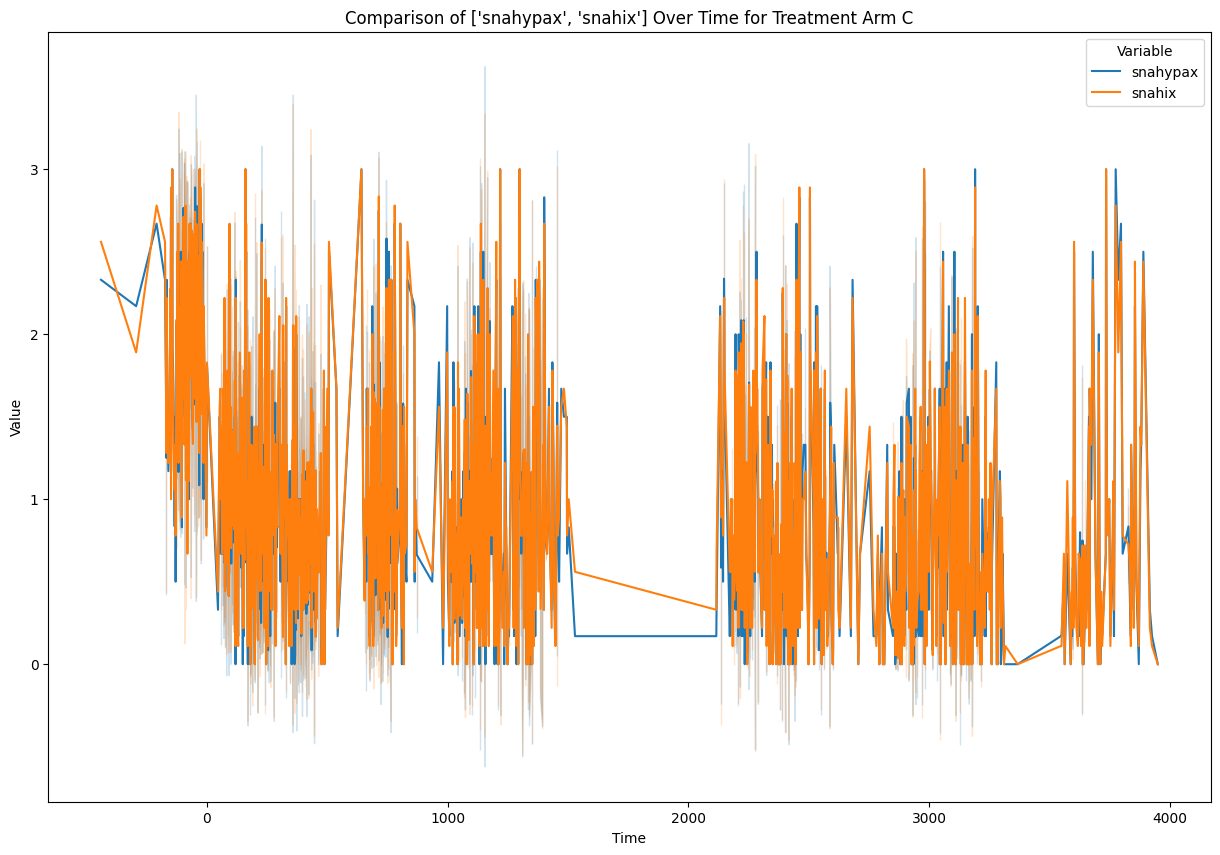

                      Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         value     
No. Observations:          5506            Method:                     REML      
No. Groups:                146             Scale:                      0.4334    
Min. group size:           10              Log-Likelihood:             -5729.7979
Max. group size:           66              Converged:                  Yes       
Mean group size:           37.7                                                  
---------------------------------------------------------------------------------
                                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                              1.651    0.037  44.187 0.000  1.578  1.724
C(variable)[T.snahypax]               -0.040    0.023  -1.742 0.082 -0.086  0.005
days_baseline                         

/var/folders/hf/frc4nxb532j7gqr3_36l6kmh0000gn/T/ipykernel_5770/2443473188.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x='days_baseline', y='value', hue='variable', data=data_long, ci='sd')


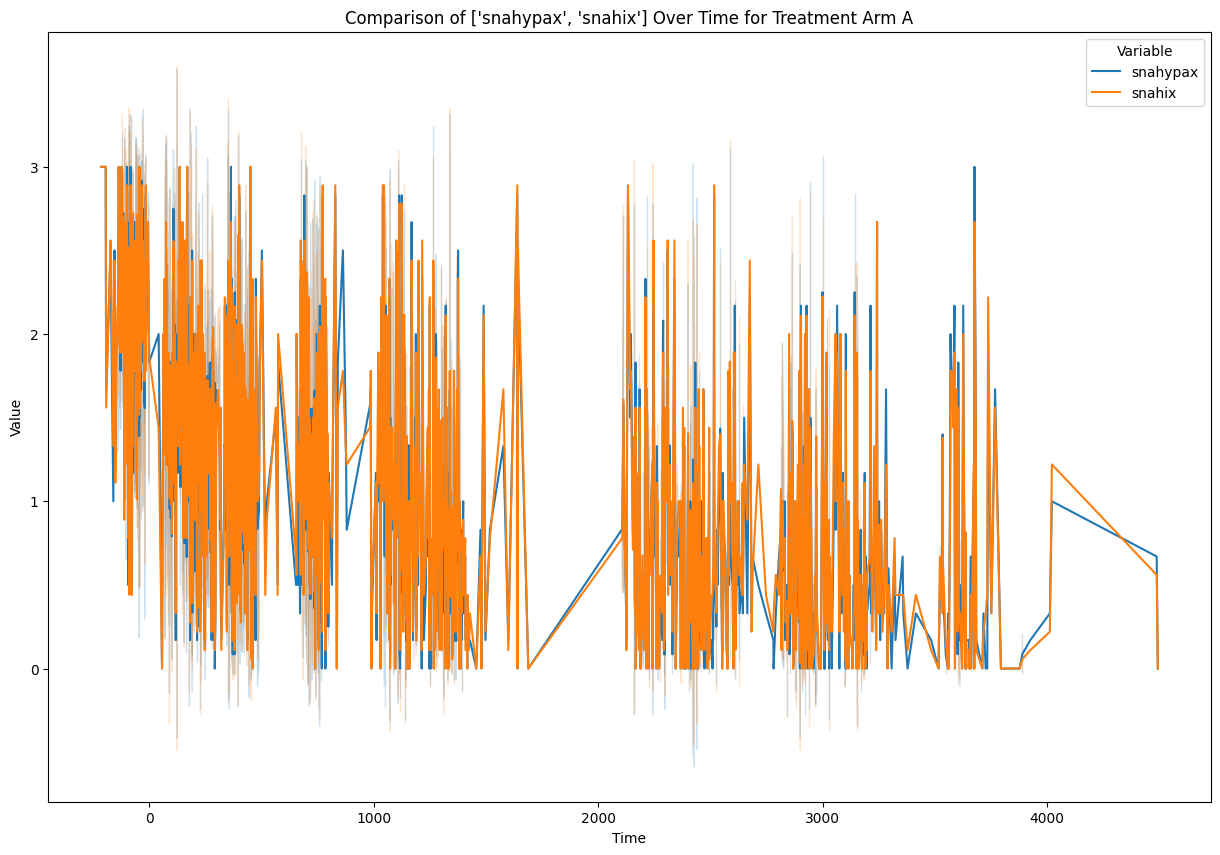

In [209]:
data = data_dict['snap']
var = 'hyp_x'
varss = snap_vars_dict[var]
for trtname in trt_names:
    compare_vars(data, varss, plot= True, trt_name= trtname)


In [142]:
var = 'hyp_x'
snap_vars_dict[var]

['snahypax', 'snap_hyp_avg', 'snahix']

In [143]:
test_lines = [plot.extract_line_plot(data_dict['snap'], snap_vars_dict[var][i], type_plot='mov_av', timepoints= None, window= 50  ) for i in range(len(snap_vars_dict[var]))]


0
SHAPE subset: (14392,) SHAPE subset sorted (14392,)
type moving average
SMOOTHED shape (14392, 2)
0
SHAPE subset: (0,) SHAPE subset sorted (0,)
type moving average
SMOOTHED shape (0, 2)
0
SHAPE subset: (14392,) SHAPE subset sorted (14392,)
type moving average
SMOOTHED shape (14392, 2)


In [89]:
qsts_vars_dict['snap']

{'ex_resp': ['snaxrsp'],
 'inatt': ['snap_inattn_totalscore',
  'snap_inattn_avg',
  'snainatx',
  'snainatt'],
 'hyp': ['snahypax', 'snahypat', 'snap_hyp_avg', 'snahix', 'snahit'],
 'odd': ['snaoddx', 'snaoddt']}

In [119]:
def extract_var_lines(data_dict, qsts_vars_dict, type_plot, window, type_return): 
    qsts_lines = {}
    var_lines = {}
    for qst in qsts:
        var_dict = qsts_vars_dict[qst]
        for var in var_dict.keys():
            lines = [plot.extract_line_plot(data_dict[qst], qsts_vars_dict[qst][var][i], type_plot='mov_av', timepoints= None, window= 50  ) for i in range(len(qsts_vars_dict[qst][var]))]
            var_lines[var] = lines
            
        qsts_lines[qst] = var_lines
        
    if type_return == 'var':
        return var_lines
    else: 
        return qsts_lines

In [120]:
var_lines_dict = extract_var_lines(data_dict, qsts_vars_dict, 'mov_av', 50,'var' )

0
SHAPE subset: (14392,) SHAPE subset sorted (14392,)
type moving average
SMOOTHED shape (14392, 2)
0
SHAPE subset: (0,) SHAPE subset sorted (0,)
type moving average
SMOOTHED shape (0, 2)
0
SHAPE subset: (0,) SHAPE subset sorted (0,)
type moving average
SMOOTHED shape (0, 2)
0
SHAPE subset: (14392,) SHAPE subset sorted (14392,)
type moving average
SMOOTHED shape (14392, 2)
0
SHAPE subset: (14392,) SHAPE subset sorted (14392,)
type moving average
SMOOTHED shape (14392, 2)
0
SHAPE subset: (14392,) SHAPE subset sorted (14392,)
type moving average
SMOOTHED shape (14392, 2)
0
SHAPE subset: (14392,) SHAPE subset sorted (14392,)
type moving average
SMOOTHED shape (14392, 2)
0
SHAPE subset: (0,) SHAPE subset sorted (0,)
type moving average
SMOOTHED shape (0, 2)
0
SHAPE subset: (14392,) SHAPE subset sorted (14392,)
type moving average
SMOOTHED shape (14392, 2)
0
SHAPE subset: (14392,) SHAPE subset sorted (14392,)
type moving average
SMOOTHED shape (14392, 2)
0
SHAPE subset: (14392,) SHAPE subse

In [121]:
var_lines_dict.keys()

dict_keys(['ex_resp', 'inatt', 'hyp', 'odd', 'ss', 'int'])

In [128]:
def plot_vars(lines,vars_list):
    plt.figure()
    for i in range(len(lines)):
        plt.plot(lines[i]['days_baseline'], lines[i]["smoothed_value"], label = vars_list[i] + " N  = " + str(lines[i].shape[0]))
    plt.legend()
    plt.show()
    

In [130]:
qsts_vars_dict

{'snap': {'ex_resp': ['snaxrsp'],
  'inatt': ['snap_inattn_totalscore',
   'snap_inattn_avg',
   'snainatx',
   'snainatt'],
  'hyp': ['snahypax', 'snahypat', 'snap_hyp_avg', 'snahix', 'snahit'],
  'odd': ['snaoddx', 'snaoddt']},
 'ssrs': {'ss': ['sspsconx', 'ssptossx'], 'int': ['sspintx']}}

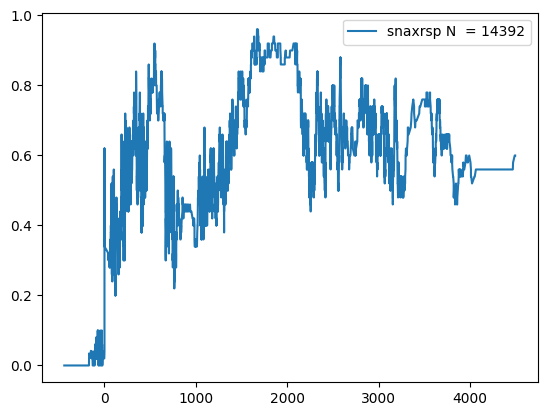

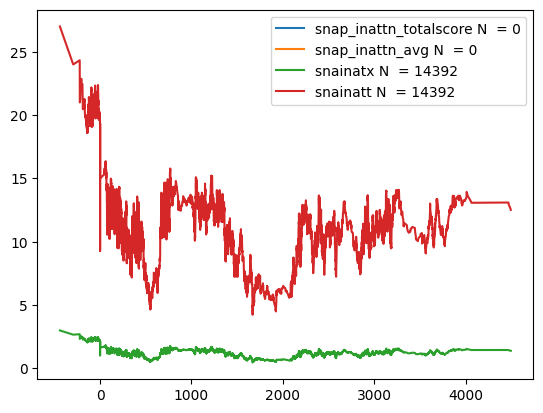

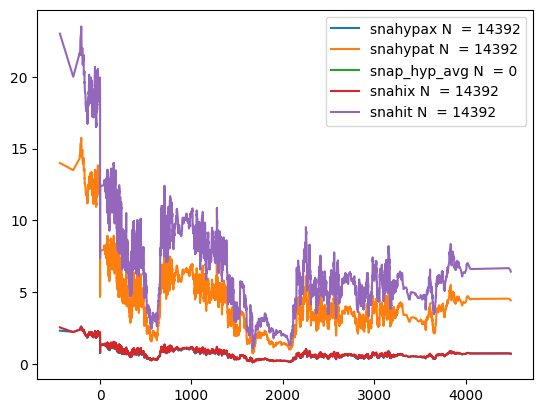

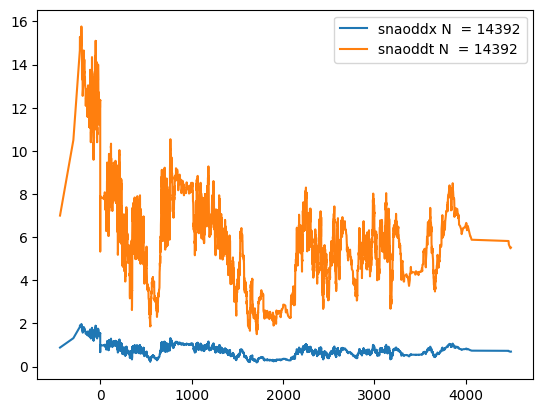

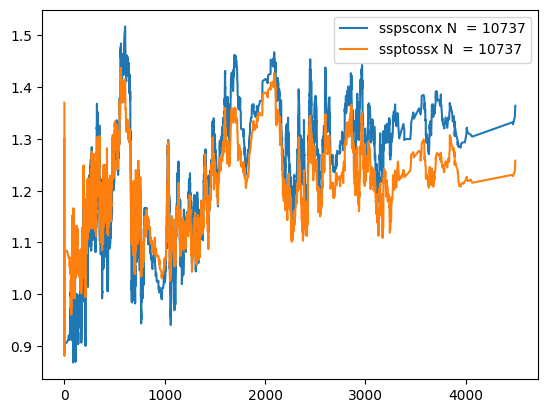

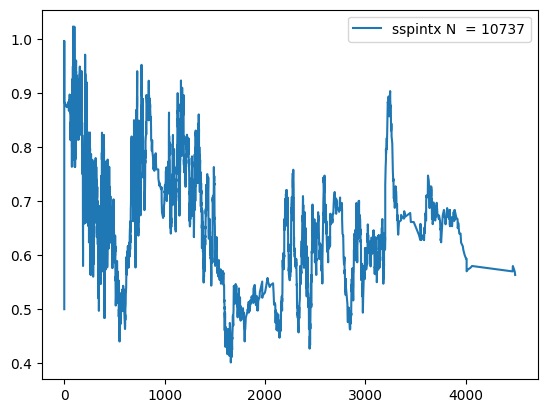

In [136]:
for key, lines in var_lines_dict.items():
    plot_vars(lines, vars_dict[key])

## Make test to see if stat diff 